In [747]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [748]:
df2a = pd.read_csv('noisy_signal.csv', header=None)
arr = df2a.values.flatten()

In [749]:
h = 1/999
omega = [1e-4, 5e-4, 1e-3]

L = np.hstack(((np.eye(999) + np.eye(999, k=1) * -1), np.zeros((999, 1)))) / h
L[-1, -1] = -999
L

array([[ 999., -999.,    0., ...,    0.,    0.,    0.],
       [   0.,  999., -999., ...,    0.,    0.,    0.],
       [   0.,    0.,  999., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., -999.,    0.,    0.],
       [   0.,    0.,    0., ...,  999., -999.,    0.],
       [   0.,    0.,    0., ...,    0.,  999., -999.]])

In [750]:
sols = [np.linalg.solve(np.eye(1000) + om * L.T @ L, arr) for om in omega]

# plt.figure(figsize=(10, 10))
# plt.scatter(np.linspace(0, 1, 1000), sols[0], label='omega = 1e-4', s=0.5)
# plt.scatter(np.linspace(0, 1, 1000), sols[1], label='omega = 5e-3', s=0.5)
# plt.scatter(np.linspace(0, 1, 1000), sols[2], label='omega = 1e-3', s=0.5)
# plt.scatter(np.linspace(0, 1, 1000), arr, label='true', s=0.5)
# plt.grid()


In [751]:
f = arr.copy()
x = arr.copy()
y = L @ x
z = np.ones(999)
u = np.vstack((x.reshape(1000, 1), y.reshape(999, 1))).flatten()

A_hat = np.hstack((np.eye(1000), np.zeros((1000, 999))))
L_hat = np.hstack((-L, np.eye(999)))
omega_bar2b = np.hstack((np.zeros(1000), 999*75*np.ones(999)))

In [752]:
def h(t, gamma):
    return np.array([gamma*t_i**2 /2 if np.abs(t_i) <= 1/gamma else np.abs(t_i) - 1/(2*gamma) for t_i in t])

In [753]:
def fn2b(u, z, gamma=1e3, lamb=5e-4):
    return 0.5 * np.linalg.norm(A_hat @ u - f)**2 + (lamb/2) * np.linalg.norm(L_hat @ u - z)**2 + np.dot(omega_bar2b, h(u, gamma))

In [754]:
def grad_fn2b(u, z, gamma=1e3, lamb=5e-4):
    return (A_hat.T @ A_hat) @ u - A_hat.T @ f + lamb * (L_hat.T@L_hat) @ u - lamb * L_hat.T @ z + (omega_bar2b * np.array([gamma * t_i if np.abs(t_i) <= 1/gamma else np.sign(t_i) for t_i in u]))

In [755]:
# def backtrack(u, z, fn, dfn, s=1, alpha=1e-4, beta=0.5):
#     t = s
#     count = 0
#     while (fn(u, z) - fn(u - t * dfn(u, z), z)) < alpha * t * np.linalg.norm(dfn(u, z))**2:
#         t = beta * t
#         count += 1
#     print(count, t)
#     return t

In [756]:
def backtrack(u, z, fn, dfn, s=1, alpha=1e-4, beta=0.5):
    t = s
    initial_fn = fn(u, z)
    gradient = dfn(u, z)
    grad_norm_sq = np.linalg.norm(gradient)**2
    count = 0
    
    while fn(u - t * gradient, z) > initial_fn - alpha * t * grad_norm_sq:
        t *= beta
        count += 1
    
    # Uncomment for debugging:
    # print(count)
    return t

In [757]:
backtrack(u, z, fn2b, grad_fn2b, s=1, alpha=1e-4, beta=0.5)

0.0009765625

In [758]:
x_old = x.copy()
u_old = u.copy()

countz = 0
while True:
    countu = 0
    for i in range(500):
        countu += 1
        u_new = u_old - backtrack(u_old, z, fn2b, grad_fn2b) * grad_fn2b(u_old, z)
        if np.linalg.norm(u_new - u_old) / np.linalg.norm(u_new) < 1e-4:
            break
        u_old = u_new
    u_old = u_new
    print('count u: ',countu)
    x_new = u_old[:1000]
    print(np.linalg.norm(x_new - x_old) / np.linalg.norm(x_new))
    if np.linalg.norm(x_new - x_old) / np.linalg.norm(x_new) < 1e-5:
        break
    x_old = x_new
    z -= (L_hat @ u_old)
    countz += 1
print('count z: ',countz)
x_new

count u:  500
0.02359518978262208
count u:  500
0.03006526501269357
count u:  500
0.035399591479081276
count u:  213
0.01597509000636667
count u:  1
4.509644963838749e-08
count z:  4


array([ 9.83811623e-01,  9.81739374e-01,  9.80288818e-01,  9.78881413e-01,
        9.78105874e-01,  9.76363968e-01,  9.75651970e-01,  9.76941480e-01,
        9.77473188e-01,  9.75088426e-01,  9.74317710e-01,  9.75865804e-01,
        9.74042080e-01,  9.73452985e-01,  9.74126993e-01,  9.77575188e-01,
        9.76897454e-01,  9.80028111e-01,  9.83698761e-01,  9.85536593e-01,
        9.87256715e-01,  9.88133711e-01,  9.89242758e-01,  9.89906450e-01,
        9.91608385e-01,  9.92548069e-01,  9.94798354e-01,  9.97544884e-01,
        9.96079575e-01,  9.97166808e-01,  9.97725671e-01,  9.98732255e-01,
        9.99494874e-01,  9.97224824e-01,  9.96750332e-01,  9.98473014e-01,
        9.99981973e-01,  1.00109177e+00,  1.00097809e+00,  1.00008422e+00,
        9.98648796e-01,  1.00030998e+00,  1.00168957e+00,  1.00141411e+00,
        1.00205561e+00,  1.00298181e+00,  1.00302216e+00,  1.00318985e+00,
        1.00411933e+00,  1.00727904e+00,  1.00669292e+00,  1.00862316e+00,
        1.00808370e+00,  

9.244639120090287

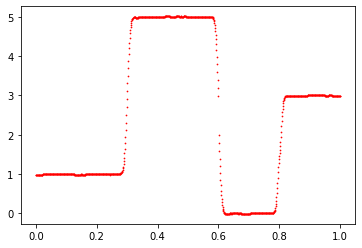

In [759]:
# plt.figure(figsize=(10, 10))    

# plt.scatter(np.linspace(0, 1, 1000), arr, label='true', s=0.5, c='black')
plt.scatter(np.linspace(0, 1, 1000), x_new, label='omega = 1e-4', s=0.5, c='red')

np.linalg.norm(x_new - arr)


In [760]:
x = arr.copy()
y = L @ x
z = np.ones(999)
lamb = 1e-2
omega = 2e-3

In [761]:
x.shape, y.shape, z.shape

((1000,), (999,), (999,))

In [762]:
def S(t, n):
    # print(t.shape, np.abs(t).shape, np.maximum(np.abs(t) - n, 0).shape)
    return (t / np.abs(t)) * np.maximum(np.abs(t) - n, 0)

In [765]:
x_old = x.copy()
y_old = y.copy()
z_old = z.copy()

count = 0
while True:
    count += 1
    x_new = np.linalg.solve(np.eye(1000) +  lamb * L.T @ L, arr.flatten() + lamb * L.T @ (y_old - z_old))
    if np.linalg.norm(x_new - x_old) / np.linalg.norm(x_new) < 1e-5:
        break
    # y_new = np.array([S(np.dot(L[i], x_new) + z_old[i], omega/lamb) for i in range(999)])
    y_new = S(L @ x_new + z_old, omega/lamb)
    z_new = z_old + L @ x_new - y_new

    x_old = x_new
    y_old = y_new
    z_old = z_new

count, x_new

(1042,
 array([1.00361866, 1.00361866, 1.00361866, 1.00361866, 1.00361866,
        1.00361865, 1.00361865, 1.00361864, 1.00361864, 1.00361863,
        1.00361862, 1.00361862, 1.00361861, 1.0036186 , 1.00361859,
        1.00361858, 1.00361857, 1.00361855, 1.00361854, 1.00361853,
        1.00361851, 1.0036185 , 1.00361848, 1.00361847, 1.00361845,
        1.00361843, 1.00361841, 1.00361839, 1.00361837, 1.00361835,
        1.00361833, 1.00361831, 1.00361829, 1.00361826, 1.00361824,
        1.00361821, 1.00361819, 1.00361816, 1.00361813, 1.00361811,
        1.00361808, 1.00361805, 1.00361802, 1.00361799, 1.00361796,
        1.00361792, 1.00361789, 1.00361786, 1.00361782, 1.00361779,
        1.00361775, 1.00361772, 1.00361768, 1.00361764, 1.0036176 ,
        1.00361756, 1.00361752, 1.00361748, 1.00361744, 1.0036174 ,
        1.00361736, 1.00361731, 1.00361727, 1.00361722, 1.00361718,
        1.00361713, 1.00361709, 1.00361704, 1.00361699, 1.00361694,
        1.00361689, 1.00361684, 1.0036167

1.6310351624015875

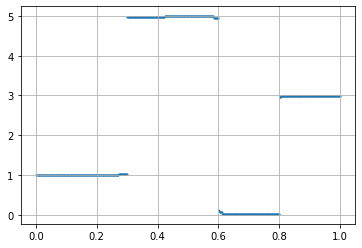

In [770]:

# plt.scatter(np.linspace(0, 1, 1000), arr, label='true', s=0.5)
plt.scatter(np.linspace(0, 1, 1000), x_new, label='true', s=0.5)
plt.grid()
np.linalg.norm(x_new - arr)